# Liveness Net

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths

In [2]:
class LivenessNet:
    @staticmethod
    def build(width, height, depth, classes):
        INPUT_SHAPE = (height, width, depth)
        chanDim = -1
        
        if tf.keras.backend.image_data_format() == 'channels_first':
            INPUT_SHAPE = (depth, height, width)
            chanDim = 1

        model = tf.keras.Sequential([
            
            tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=INPUT_SHAPE),
            tf.keras.layers.BatchNormalization(axis=chanDim),
            tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(axis=chanDim),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Dropout(0.25),

            tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(axis=chanDim),
            tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(axis=chanDim),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Dropout(0.25),

            tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(axis=chanDim),
            tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(axis=chanDim),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Dropout(0.25),
            
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
            
            tf.keras.layers.Dense(classes, activation='softmax')
        ])
        
        return model

In [3]:
def load_and_preprocess_images(imagePaths, img_size=(64, 64)):
    data = []
    labels = []
    for imagePath in imagePaths:
        label = imagePath.split(os.path.sep)[-2]
        image = cv2.imread(imagePath)
        image = cv2.resize(image, img_size)
        data.append(image)
        labels.append(label)
    data = np.array(data, dtype='float') 
    return data, labels

[INFO] Đang tải hình ảnh...
[INFO] Đang biên dịch mô hình...
[INFO] Đang huấn luyện mô hình trong 50 epochs...
Epoch 1/50
19/19 [==============================] - 3s 75ms/step - loss: 0.9227 - accuracy: 0.5778 - val_loss: 1.2028 - val_accuracy: 0.3205
Epoch 2/50
19/19 [==============================] - 1s 60ms/step - loss: 0.7115 - accuracy: 0.7163 - val_loss: 1.3216 - val_accuracy: 0.3205
Epoch 3/50
19/19 [==============================] - 1s 59ms/step - loss: 0.5980 - accuracy: 0.7823 - val_loss: 1.5041 - val_accuracy: 0.3205
Epoch 4/50
19/19 [==============================] - 1s 59ms/step - loss: 0.5374 - accuracy: 0.8005 - val_loss: 1.5534 - val_accuracy: 0.3223
Epoch 5/50
19/19 [==============================] - 1s 63ms/step - loss: 0.5172 - accuracy: 0.8253 - val_loss: 1.1934 - val_accuracy: 0.3462
Epoch 6/50
19/19 [==============================] - 1s 61ms/step - loss: 0.4430 - accuracy: 0.8543 - val_loss: 1.0790 - val_accuracy: 0.4194
Epoch 7/50
19/19 [=========================

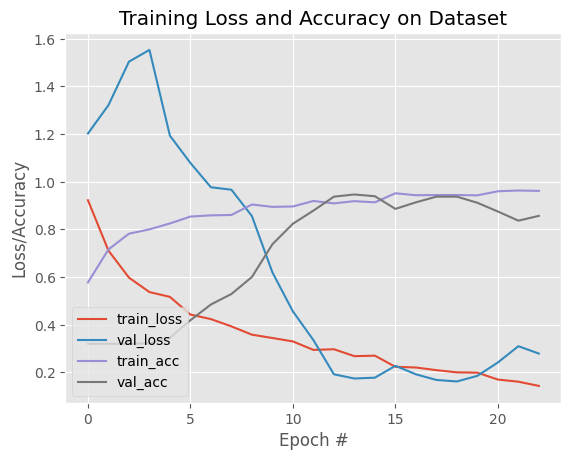

In [6]:
dataset_path = 'MMT/New folder (2)'

model_path = 'output_model.h5'
label_encoder_path = 'output_label_encoder.pickle'
plot_path = 'output_plot.png'

print('[INFO] Đang tải hình ảnh...')
imagePaths = list(paths.list_images(dataset_path))
data, labels = load_and_preprocess_images(imagePaths)

le = LabelEncoder()
labels = le.fit_transform(labels)
labels = tf.keras.utils.to_categorical(labels, 2)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

aug = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=10, 
                                                      zoom_range=0.15,
                                                      width_shift_range=0.2,
                                                      height_shift_range=0.2,
                                                      shear_range=0.15,
                                                      horizontal_flip=True,
                                                      fill_mode='nearest')

INIT_LR = 1e-4
BATCH_SIZE = 64
EPOCHS = 50

print('[INFO] Đang biên dịch mô hình...')
optimizer = tf.keras.optimizers.Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model = LivenessNet.build(width=64, height=64, depth=3, classes=len(le.classes_))
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

print(f'[INFO] Đang huấn luyện mô hình trong {EPOCHS} epochs...')
history = model.fit(x=aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
                    validation_data=(X_test, y_test),
                    steps_per_epoch=len(X_train) // BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=[early_stopping])

print('[INFO] Đang đánh giá mạng...')
predictions = model.predict(x=X_test, batch_size=BATCH_SIZE)
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=le.classes_))

print(f"[INFO] Đang lưu mạng vào '{model_path}'")
model.save(model_path, save_format='h5')

with open(label_encoder_path, 'wb') as file:
    file.write(pickle.dumps(le))

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, len(history.history['loss'])), history.history['loss'], label='train_loss')
plt.plot(np.arange(0, len(history.history['val_loss'])), history.history['val_loss'], label='val_loss')
plt.plot(np.arange(0, len(history.history['accuracy'])), history.history['accuracy'], label='train_acc')
plt.plot(np.arange(0, len(history.history['val_accuracy'])), history.history['val_accuracy'], label='val_acc')
plt.title('Training Loss and Accuracy on Dataset')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend(loc='lower left')
plt.savefig(plot_path)


9/9 [==============================] - 0s 34ms/step


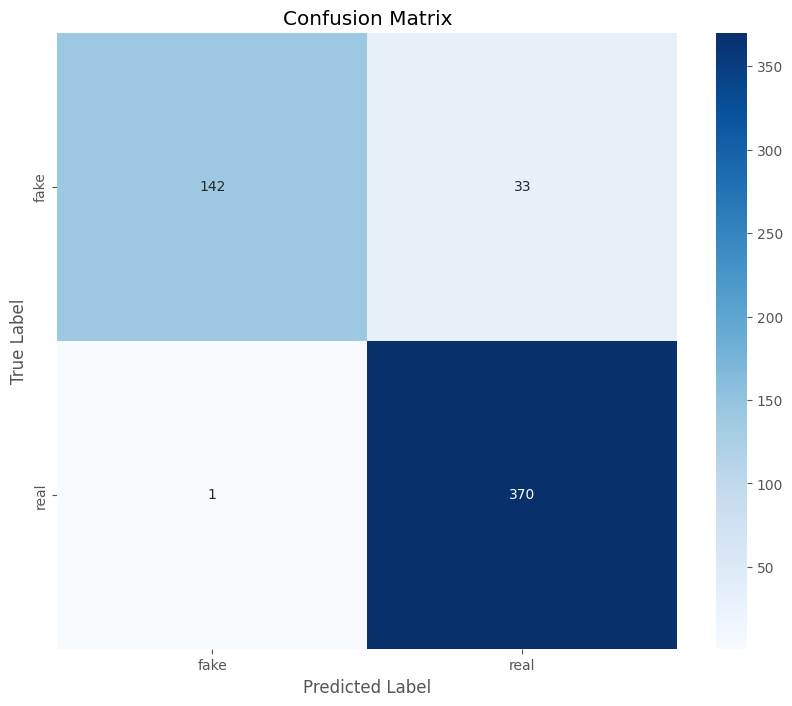

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

predictions = model.predict(x=X_test, batch_size=BATCH_SIZE)
y_pred = predictions.argmax(axis=1)

y_true = y_test.argmax(axis=1)

# Xây dựng ma trận nhầm lẫn
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()